In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import os.path
import math
from xgboost import XGBClassifier
from sklearn.externals import joblib
import pandas as pd

n_bytes = 2**31
max_bytes = 2**31 - 1

class Time_Tracking():
    
    start_time = None
    
    def start_tracking(self):
        
        self.start_time = time.time()
    
    def stop_tracking(self):
        
        print("Time used:", round(((time.time() - self.start_time)/60),2), ' minutes')


def load_pickle(file_path):
    
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    
    return pickle.loads(bytes_in)

In [2]:
model = joblib.load("xgb.pickle.dat")

train = load_pickle('train_df_after_preprocessing.pkl')
valid = load_pickle('valid_df_after_preprocessing.pkl')
test = load_pickle('test_df_after_preprocessing.pkl')

valid_click = valid['click']
valid_bidprice = valid['bidprice']
valid_payprice = valid['payprice']
valid_X = valid.drop(['click', 'bidprice', 'payprice'], axis = 1)

In [3]:
valid_ctr_prediction = model.predict_proba(valid_X)

# ORTB: bid_price = sqrt( pCTR*C\lambda + C^2) - C

In [4]:
def EvaluateClick( bid_price, budget, valid_payprice, valid_click):
    
    auction = bid_price >= valid_payprice
    win_bid_ix = [ index for index,auc in enumerate(auction) if auc ]
    bid_spends = valid_payprice[win_bid_ix].values
    bid_clicks = valid_click[win_bid_ix].values

    budget = 6250000
    current_spend = sum(bid_spends)

    total_bids = len(bid_spends)

    for i in range(len(bid_spends)):

        current_spend -= bid_spends[total_bids-i-1]

        if current_spend <= budget:
            break

    final_win_bid_ix = win_bid_ix[:(total_bids - i -1)]
    bid_spends = sum(valid_payprice[final_win_bid_ix].values)
    bid_clicks = sum(valid_click[final_win_bid_ix].values)
    
    print('clicks:', bid_clicks, 'impressions:', len(final_win_bid_ix), 'spend:', bid_spends)

    return bid_clicks


In [5]:
budget = 6250000
valid_pctr = valid_ctr_prediction[:,1]

In [6]:
C = np.arange(1,100,5)
lamda=np.arange(5*10**(-4),8*10**(-4),10**(-5))
clicks = []

for c in C:
    for lamdas in lamda:
        bid_price = [ int(math.sqrt(pCTR * c / lamdas + c**2) - c ) for pCTR in valid_pctr ]
        click = EvaluateClick( bid_price, budget , valid_payprice, valid_click )
    clicks.append(click)

# plt.figure()
# plt.plot(c, lamdas, clicks)
print('best c:', C[clicks.index(max(clicks))])
print('best l:', lamda[clicks.index(max(clicks))])

    
    


clicks: 22 impressions: 41825 spend: 600553
clicks: 21 impressions: 41221 spend: 586251
clicks: 21 impressions: 40626 spend: 572818
clicks: 21 impressions: 40072 spend: 560123
clicks: 20 impressions: 39424 spend: 545969
clicks: 20 impressions: 38805 spend: 532302
clicks: 19 impressions: 38342 spend: 522185
clicks: 19 impressions: 37796 spend: 510414
clicks: 19 impressions: 37314 spend: 500203
clicks: 19 impressions: 36836 spend: 489833
clicks: 19 impressions: 36375 spend: 480066
clicks: 19 impressions: 35946 spend: 470955
clicks: 19 impressions: 35458 spend: 460496
clicks: 19 impressions: 35050 spend: 451796
clicks: 19 impressions: 34618 spend: 442939
clicks: 19 impressions: 34232 spend: 434859
clicks: 19 impressions: 33868 spend: 427287
clicks: 19 impressions: 33478 spend: 419222
clicks: 19 impressions: 33065 spend: 410788
clicks: 19 impressions: 32722 spend: 403982
clicks: 19 impressions: 32362 spend: 396442
clicks: 19 impressions: 32019 spend: 389393
clicks: 18 impressions: 31687 sp

clicks: 122 impressions: 150599 spend: 6249954
clicks: 127 impressions: 151245 spend: 6249991
clicks: 95 impressions: 124933 spend: 6249965
clicks: 96 impressions: 125797 spend: 6249994
clicks: 98 impressions: 126599 spend: 6249999
clicks: 100 impressions: 127427 spend: 6249988
clicks: 102 impressions: 128198 spend: 6249898
clicks: 103 impressions: 128973 spend: 6249954
clicks: 102 impressions: 129719 spend: 6249930
clicks: 103 impressions: 130422 spend: 6249963
clicks: 105 impressions: 131201 spend: 6249968
clicks: 104 impressions: 131854 spend: 6249988
clicks: 107 impressions: 132669 spend: 6249991
clicks: 107 impressions: 133479 spend: 6249938
clicks: 106 impressions: 134195 spend: 6249996
clicks: 106 impressions: 134884 spend: 6249991
clicks: 107 impressions: 135668 spend: 6249994
clicks: 109 impressions: 136401 spend: 6249989
clicks: 109 impressions: 137102 spend: 6249983
clicks: 108 impressions: 137743 spend: 6249976
clicks: 107 impressions: 138376 spend: 6249965
clicks: 108 impr

clicks: 105 impressions: 126681 spend: 6249948
clicks: 106 impressions: 127314 spend: 6249940
clicks: 105 impressions: 127887 spend: 6249997
clicks: 106 impressions: 128455 spend: 6249928
clicks: 105 impressions: 129013 spend: 6249966
clicks: 107 impressions: 129530 spend: 6250000
clicks: 84 impressions: 108949 spend: 6249985
clicks: 86 impressions: 109653 spend: 6249963
clicks: 87 impressions: 110322 spend: 6249991
clicks: 87 impressions: 111019 spend: 6249949
clicks: 88 impressions: 111729 spend: 6249981
clicks: 88 impressions: 112410 spend: 6250000
clicks: 89 impressions: 113041 spend: 6249959
clicks: 91 impressions: 113732 spend: 6249979
clicks: 91 impressions: 114414 spend: 6249964
clicks: 91 impressions: 115110 spend: 6249920
clicks: 91 impressions: 115708 spend: 6249950
clicks: 92 impressions: 116361 spend: 6249999
clicks: 92 impressions: 116970 spend: 6249987
clicks: 94 impressions: 117652 spend: 6249987
clicks: 94 impressions: 118252 spend: 6249951
clicks: 95 impressions: 1189

clicks: 94 impressions: 116079 spend: 6249989
clicks: 97 impressions: 116720 spend: 6249902
clicks: 96 impressions: 117353 spend: 6249960
clicks: 98 impressions: 117913 spend: 6249938
clicks: 97 impressions: 118528 spend: 6249942
clicks: 98 impressions: 119029 spend: 6249927
clicks: 99 impressions: 119571 spend: 6249932
clicks: 99 impressions: 120094 spend: 6249935
clicks: 77 impressions: 102473 spend: 6249977
clicks: 77 impressions: 103019 spend: 6249996
clicks: 79 impressions: 103567 spend: 6249954
clicks: 79 impressions: 104105 spend: 6249951
clicks: 79 impressions: 104594 spend: 6249963
clicks: 80 impressions: 105167 spend: 6249991
clicks: 81 impressions: 105669 spend: 6249983
clicks: 82 impressions: 106213 spend: 6249978
clicks: 83 impressions: 106806 spend: 6249859
clicks: 84 impressions: 107401 spend: 6249950
clicks: 84 impressions: 108044 spend: 6249946
clicks: 87 impressions: 108603 spend: 6249988
clicks: 88 impressions: 109201 spend: 6249934
clicks: 89 impressions: 109862 spe

clicks: 128 impressions: 147542 spend: 5716499
clicks: 128 impressions: 146217 spend: 5627713
clicks: 128 impressions: 144874 spend: 5539446
clicks: 127 impressions: 143523 spend: 5450520
clicks: 127 impressions: 142185 spend: 5362418
clicks: 127 impressions: 140912 spend: 5278022
clicks: 126 impressions: 139576 spend: 5191984
clicks: 124 impressions: 138392 spend: 5115760
clicks: 124 impressions: 137172 spend: 5037331
clicks: 123 impressions: 135991 spend: 4960852
clicks: 121 impressions: 134769 spend: 4882147
clicks: 120 impressions: 133502 spend: 4802170
clicks: 120 impressions: 132345 spend: 4730417
clicks: 119 impressions: 131106 spend: 4652875
clicks: 118 impressions: 129975 spend: 4581563
clicks: 117 impressions: 128824 spend: 4510675
clicks: 117 impressions: 127731 spend: 4444368
clicks: 117 impressions: 126665 spend: 4379221
clicks: 117 impressions: 125547 spend: 4311327
clicks: 116 impressions: 124502 spend: 4247949
clicks: 115 impressions: 123507 spend: 4188643
clicks: 114 i

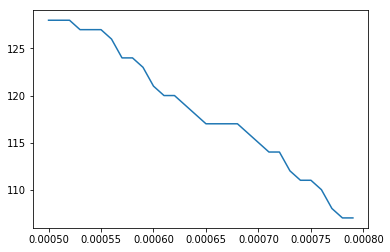

In [7]:
c=10.58
lamda=np.arange(5*10**(-4),8*10**(-4),10**(-5))
clicks = []

for lamdas in lamda:
    bid_price = [ int(math.sqrt(pCTR * c / lamdas + c**2) - c ) for pCTR in valid_pctr ]
    click = EvaluateClick( bid_price, budget , valid_payprice, valid_click)
    clicks.append(click)

plt.figure()
plt.plot(lamda, clicks)
print('best lamda:', lamda[clicks.index(max(clicks))])

clicks: 127 impressions: 141887 spend: 5337523
clicks: 128 impressions: 146823 spend: 5672340
clicks: 130 impressions: 151058 spend: 5966930
clicks: 133 impressions: 154852 spend: 6240603
clicks: 122 impressions: 152240 spend: 6249991
clicks: 114 impressions: 149617 spend: 6249964
clicks: 116 impressions: 147253 spend: 6249986
clicks: 114 impressions: 145075 spend: 6249971
clicks: 112 impressions: 143078 spend: 6249985
clicks: 108 impressions: 141210 spend: 6249998
best c: 13


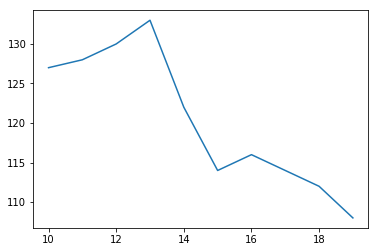

In [12]:
C = np.arange(10,20,1)
lamdas = 0.00052
clicks = []

for c in C:
    bid_price = [ int(math.sqrt(pCTR * c / lamdas + c**2) - c ) for pCTR in valid_pctr ]
    click = EvaluateClick( bid_price, budget , valid_payprice, valid_click)
    clicks.append(click)

plt.figure()
plt.plot(C, clicks)
print('best c:', C[clicks.index(max(clicks))])

In [13]:
lamda = 5.2*10**(-4)
c = 13

bid_price = [ int(math.sqrt(pCTR * c / lamda + c**2) - c ) for pCTR in valid_pctr ]
EvaluateClick( bid_price, budget , valid_payprice, valid_click)

clicks: 133 impressions: 154852 spend: 6240603


133

In [9]:
lamda = 7*10**(-4)
c = 16

bid_price = [ int(math.sqrt(pCTR * c / lamda + c**2) - c ) for pCTR in valid_pctr ]
EvaluateClick( bid_price, budget , valid_payprice, valid_click)

clicks: 128 impressions: 144284 spend: 5551422


128

In [10]:
submission = pd.read_csv('Group_xx.csv')
test_prediction = model.predict_proba(test)[:,1]
lamda = 5.33*10**(-4)
c = 10.58
bid_price = [ int(math.sqrt(pCTR * c / lamda + c**2) - c ) for pCTR in test_prediction ]

submission['bidprice'] = bid_price
submission.to_csv('XGB_with_ORTB.csv')